<a href="https://colab.research.google.com/github/ZosoV/aco_random_walk/blob/main/notebooks/display_pheromones_exploration_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pheromones and Exploration Distribution

In this notebook, we tested how the random walks leave a trace over the environment and how this trace approximates the ACO trace in the convergence point.

In [1]:
COLAB_ENV = False

if COLAB_ENV:
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd /content/gdrive/MyDrive/Proyectos/aco_random_walk/
else:
    %cd /home/israel.pineda/oscar/aco_random_walk/

/home/israel.pineda/oscar/aco_random_walk


In [2]:
!ls

environment.yml  model	    random_walk  stuff	      test_aco_rw.py  utils
LICENSE		 notebooks  README.md	 test_aco.py  test_rw.py


In [3]:
# import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import enum
import numpy as np
import os
import pandas as pd
from collections import Counter
import time
import pylab as pl
from IPython import display

import model.graph_env as ge
import random_walk.rw_models as rw
from functools import partial

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED) 

In [4]:
REFERENCE_DIR = "stuff/distribution"
SAVE_DIR = "stuff/results/distributions"

In [5]:
!ls $REFERENCE_DIR

env_100_exploration_acu.npy  env_50_exploration_acu.npy
env_100_exploration_avg.npy  env_50_exploration_avg.npy
env_100_pheromones_acu.npy   env_50_pheromones_acu.npy
env_100_pheromones_avg.npy   env_50_pheromones_avg.npy
env_10_exploration_acu.npy   env_60_exploration_acu.npy
env_10_exploration_avg.npy   env_60_exploration_avg.npy
env_10_pheromones_acu.npy    env_60_pheromones_acu.npy
env_10_pheromones_avg.npy    env_60_pheromones_avg.npy
env_20_exploration_acu.npy   env_70_exploration_acu.npy
env_20_exploration_avg.npy   env_70_exploration_avg.npy
env_20_pheromones_acu.npy    env_70_pheromones_acu.npy
env_20_pheromones_avg.npy    env_70_pheromones_avg.npy
env_30_exploration_acu.npy   env_80_exploration_acu.npy
env_30_exploration_avg.npy   env_80_exploration_avg.npy
env_30_pheromones_acu.npy    env_80_pheromones_acu.npy
env_30_pheromones_avg.npy    env_80_pheromones_avg.npy
env_40_exploration_acu.npy   env_90_exploration_acu.npy
env_40_exploration_avg.npy   env_90_exploration_avg.npy


In [6]:
#@title Function to plot the best distance per iteration
def plot_change(y_values, yerror = None, save = False, add_title = "", name2save = ""):

  list_iterations = np.arange(0, len(y_values[0]))
  #path_to_save = "stuff/figures/"
  #if not os.path.exists(path_to_save):
  #    os.mkdir(path_to_save)

  title = 'Similarity Distance vs Iterations\n'
  title += add_title

  plt.title(title)
  if yerror is not None:
        
    markers, caps, bars = plt.errorbar(list_iterations, y_values, yerr=yerror, color = "b")

  else:
    for y_val in y_values:
        plt.plot(list_iterations, y_val) #, label = label)
  #plt.legend()
  #if save: plt.savefig(os.path.join(path_to_save,name2save))
  plt.xlabel("iterations")
  plt.ylabel("similarity")
    
  plt.show()
  plt.close()

In [7]:
#@title Function to plot the graph in a grid prespective, the pheromones and exploration
def plot_matrixes(pheromones = None, exploration = None):

  def pheromones_plot(fig, ax):
      im = ax.pcolor(pheromones, edgecolors='k', cmap='viridis', linewidths=0.2)
      ax.set_title('Pheromones Distribution')
      ax.set_aspect('equal') #set the x and y axes to the same scale
      ax.set_xticks([])
      ax.set_yticks([])
      ax.invert_yaxis() #invert the y-axis so the first row of data is at the top
      
      cbar=fig.colorbar(im, label='pheromones amount', ax = ax)
    
  def exploration_plot(fig, ax):
      im2 = ax.pcolor(exploration, edgecolors='k', cmap='plasma', linewidths=0.2)
      ax.set_title('Exploration')
      ax.set_aspect('equal') #set the x and y axes to the same scale
      ax.set_xticks([])
      ax.set_yticks([])
      ax.invert_yaxis() #invert the y-axis so the first row of data is at the top
      
      cbar=fig.colorbar(im2, label='number of times visited', ax = ax)
    
  fig, ax = plt.subplots(figsize=(2*6,6))

  ax1 = plt.subplot(121)
  ax2 = plt.subplot(122)

  #ax4 = plt.subplot(212)

  #Plot the maze
  
  if pheromones is not None:
      pheromones_plot(fig,ax1)
    
  if exploration is not None:
      exploration_plot(fig,ax2)


In [8]:
def plot_many_distances(data, x_values = [], legend_labels = [], 
                        legend_title = "var params",  title = "", 
                        save = False , name2save = "default",
                        ylim = None, xlim = None, xlabel = "# Random Walks", ylabel = ""):

  markers = ['o','s','v','D','x','+','p','H','*','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d','|','_']

  # title = 'Average Distance vs Iterations \n' + title
  figure(figsize=(6, 5))#, dpi=80)
  plt.title(title)
  
  i = 0
  for label, distances in zip(legend_labels, data):
    print(f"min dist: {np.amin(distances)}")
    plt.plot(x_values, distances, "-", label = str(label))#, marker = markers[i])
    i += 1

  plt.legend(title=legend_title)
  if ylim is not None:
    plt.ylim(ylim[0], ylim[1])
  if xlim is not None:
    plt.xlim(xlim[0], xlim[1])
    
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  if save: plt.savefig(os.path.join(SAVE_DIR,name2save + ".eps"), format='eps')

  plt.show()
  plt.close()

# Greedy Walker -> Distribution

In [138]:
NUM_RW = 500
TAU_0 = [0.001, 0.005, 0.01]
SIZE = 50
q_0 = 0
advantage = 3

pheromones_per_tau = []
exploration_per_tau = []

for tau_0_value in TAU_0:
    graph = ge.PPGraph(size=SIZE, tau_0=tau_0_value)
    walker = rw.GreedyWalker(graph, q_0 = q_0, advantage = advantage)
    
    pheromones_iter = []
    exploration_iter = []

    for i in range(NUM_RW):
        _ = walker.walk(1, verbose = False)
        walker.reinforce_rw()
        pheromones = walker.graph.get_pheromones_matrix()
        exploration = walker.graph.get_exploration_matrix()

        pheromones_iter.append(pheromones)
        exploration_iter.append(exploration)
        
    pheromones_per_tau.append(pheromones_iter)
    exploration_per_tau.append(exploration_iter)

np.save(os.path.join(SAVE_DIR,f"pheromones_env_{SIZE}_q0_{q_0}_omega_{advantage}_rw_{NUM_RW}.npy"),
           np.array(pheromones_per_tau))
np.save(os.path.join(SAVE_DIR,f"exploration_env_{SIZE}_q0_{q_0}_omega_{advantage}_rw_{NUM_RW}.npy"),
           np.array(exploration_per_tau))

In [139]:
q_0 = 0
NUM_RW = 500

# Loading references and random walk results
exp_pheromone = np.load(os.path.join(SAVE_DIR,f"pheromones_env_50_q0_{q_0}_omega_3_rw_{NUM_RW}.npy"))
exp_exploration = np.load(os.path.join(SAVE_DIR,f"exploration_env_50_q0_{q_0}_omega_3_rw_{NUM_RW}.npy"))
ref_pheromone = np.load(os.path.join(REFERENCE_DIR, "env_50_pheromones_avg.npy"))
ref_exploration = np.load(os.path.join(REFERENCE_DIR, "env_50_exploration_avg.npy"))
exp_pheromone.shape
# comment

(3, 500, 50, 50)

In [140]:
# measure the distances of pheromone representations
pheromone_distances = ((exp_pheromone - ref_pheromone[np.newaxis,np.newaxis]) ** 2).sum(axis=(2,3))
pheromone_distances = np.sqrt(pheromone_distances)
print(pheromone_distances.shape)

# measure the distance of exploration representations
exploration_distances = ((exp_exploration - ref_exploration[np.newaxis,np.newaxis]) ** 2).sum(axis=(2,3))
exploration_distances = np.sqrt(exploration_distances)
print(exploration_distances.shape)

(3, 500)
(3, 500)


min dist: 0.15635806238642735
min dist: 0.1375722521889755
min dist: 0.3271937333594125


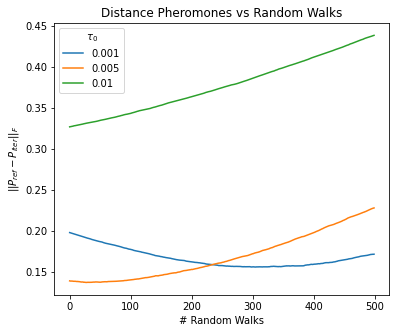

In [141]:
plot_many_distances(pheromone_distances, x_values = list(range(NUM_RW)), legend_labels = TAU_0, 
                        legend_title = r"$\tau_0$",  title = "Distance Pheromones vs Random Walks", ylabel = r"$||P_{ref} - P_{iter}||_F$")

min dist: 1130.410581258961
min dist: 1073.860488559333
min dist: 1093.546744415721


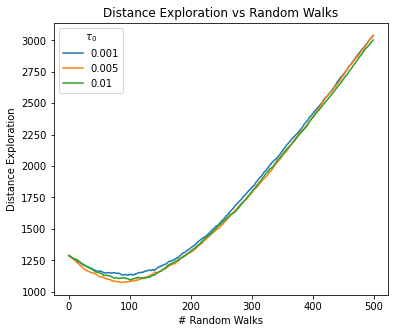

In [142]:
plot_many_distances(exploration_distances, x_values = list(range(NUM_RW)), legend_labels = TAU_0, 
                        legend_title = r"$\tau_0$",  title = "Distance Exploration vs Random Walks", ylabel = "Distance Exploration")

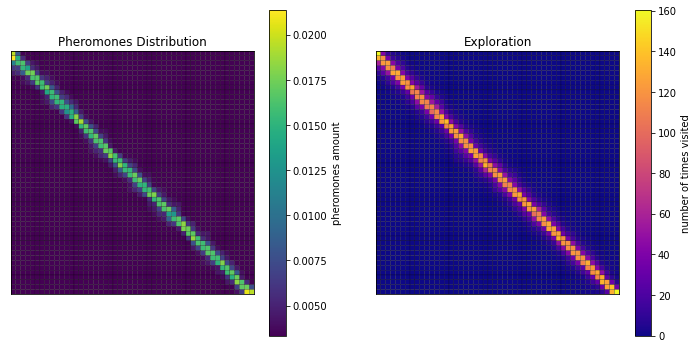

In [143]:
plot_matrixes(ref_pheromone, ref_exploration)

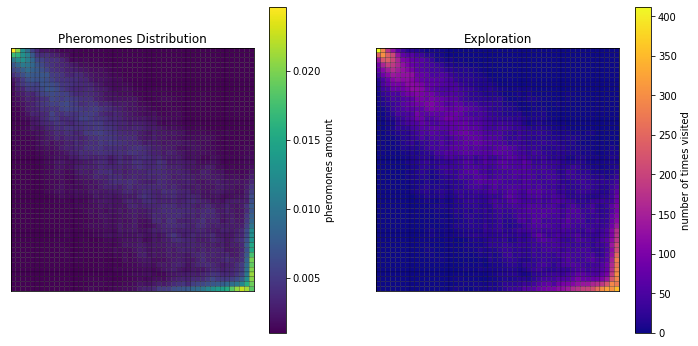

In [146]:
# tau_idx-> 0: 0.001, 1: 0.005, 2: 0.01
tau_idx = 0
iter = 350 
plot_matrixes(exp_pheromone[tau_idx,iter], exp_exploration[tau_idx,iter])

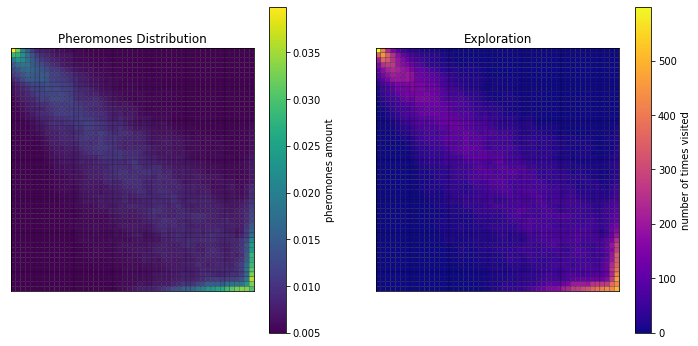

In [145]:
# tau_idx-> 0: 0.001, 1: 0.005, 2: 0.01
tau_idx = 1
iter = -1 

plot_matrixes(exp_pheromone[tau_idx,iter], exp_exploration[tau_idx,iter])

# Proximity Walker -> Distribution

In [12]:
NUM_RW = 500
TAU_0 = [0.001, 0.005, 0.01]
SIZE = 50
q_0 = 0

In [147]:
NUM_RW = 500
TAU_0 = [0.001, 0.005, 0.01]
SIZE = 50
q_0 = 0
proximity = "proximity_1"

pheromones_per_tau = []
exploration_per_tau = []

for tau_0_value in TAU_0:
    graph = ge.PPGraph(size=SIZE, tau_0=tau_0_value)
    walker = rw.ProximityWalker(graph, q_0 = q_0, proximity_mode = proximity)
    
    pheromones_iter = []
    exploration_iter = []

    for i in range(NUM_RW):
        _ = walker.walk(1, verbose = False)
        walker.reinforce_rw()
        pheromones = walker.graph.get_pheromones_matrix()
        exploration = walker.graph.get_exploration_matrix()

        pheromones_iter.append(pheromones)
        exploration_iter.append(exploration)
        
    pheromones_per_tau.append(pheromones_iter)
    exploration_per_tau.append(exploration_iter)

np.save(os.path.join(SAVE_DIR,f"pheromones_env_{SIZE}_q0_{q_0}_{proximity}_rw_{NUM_RW}.npy"),
           np.array(pheromones_per_tau))
np.save(os.path.join(SAVE_DIR,f"exploration_env_{SIZE}_q0_{q_0}_{proximity}_rw_{NUM_RW}.npy"),
           np.array(exploration_per_tau))

# q_0 = 0

In [9]:
q_0 = 0
NUM_RW = 500

# Loading references and random walk results
exp_pheromone = np.load(os.path.join(SAVE_DIR,f"pheromones_env_50_q0_{q_0}_omega_3_rw_{NUM_RW}.npy"))
exp_exploration = np.load(os.path.join(SAVE_DIR,f"exploration_env_50_q0_{q_0}_omega_3_rw_{NUM_RW}.npy"))
ref_pheromone = np.load(os.path.join(REFERENCE_DIR, "env_50_pheromones_avg.npy"))
ref_exploration = np.load(os.path.join(REFERENCE_DIR, "env_50_exploration_avg.npy"))
exp_pheromone.shape

(3, 500, 50, 50)

In [10]:
# measure the distances of pheromone representations
pheromone_distances = ((exp_pheromone - ref_pheromone[np.newaxis,np.newaxis]) ** 2).sum(axis=(2,3))
pheromone_distances = np.sqrt(pheromone_distances)
print(pheromone_distances.shape)

# measure the distance of exploration representations
exploration_distances = ((exp_exploration - ref_exploration[np.newaxis,np.newaxis]) ** 2).sum(axis=(2,3))
exploration_distances = np.sqrt(exploration_distances)
print(exploration_distances.shape)

(3, 500)
(3, 500)


min dist: 0.15635806238642735
min dist: 0.1375722521889755
min dist: 0.3271937333594125


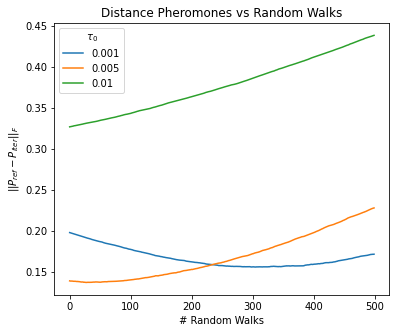

In [13]:
plot_many_distances(pheromone_distances, x_values = list(range(NUM_RW)), legend_labels = TAU_0, 
                        legend_title = r"$\tau_0$",  title = "Distance Pheromones vs Random Walks", ylabel = r"$||P_{ref} - P_{iter}||_F$")

min dist: 1130.410581258961
min dist: 1073.860488559333
min dist: 1093.546744415721


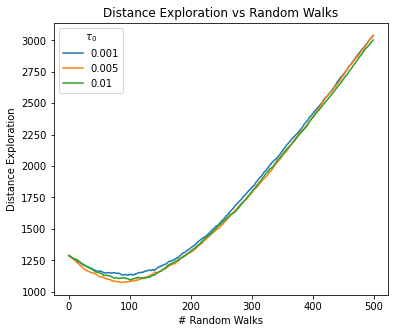

In [14]:
plot_many_distances(exploration_distances, x_values = list(range(NUM_RW)), legend_labels = TAU_0, 
                        legend_title = r"$\tau_0$",  title = "Distance Exploration vs Random Walks", ylabel = "Distance Exploration")

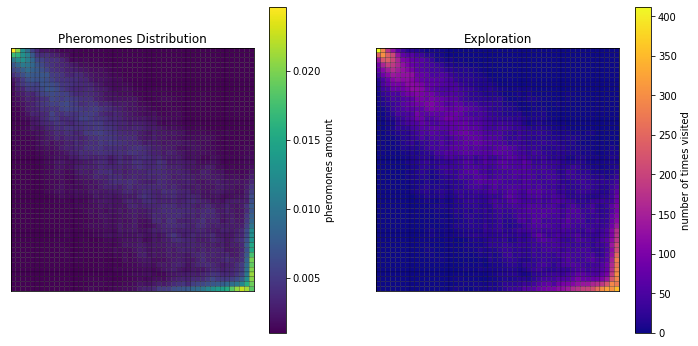

In [15]:
# tau_idx-> 0: 0.001, 1: 0.005, 2: 0.01
tau_idx = 0
iter = 350 
plot_matrixes(exp_pheromone[tau_idx,iter], exp_exploration[tau_idx,iter])

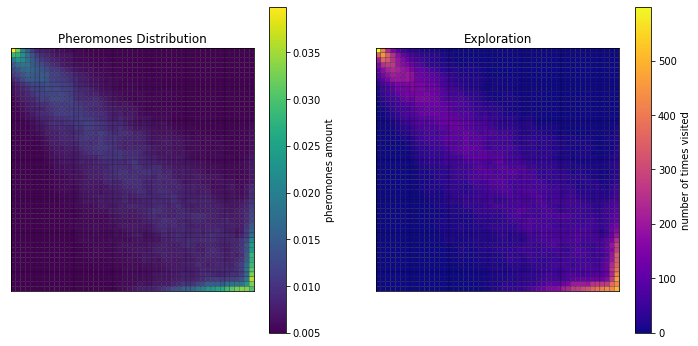

In [16]:
# tau_idx-> 0: 0.001, 1: 0.005, 2: 0.01
tau_idx = 1
iter = -1 

plot_matrixes(exp_pheromone[tau_idx,iter], exp_exploration[tau_idx,iter])

# q_0 = 0.5

In [ ]:
q_0 = 0.5
NUM_RW = 500

# Loading references and random walk results
exp_pheromone = np.load(os.path.join(SAVE_DIR,f"pheromones_env_50_q0_{q_0}_omega_3_rw_{NUM_RW}.npy"))
exp_exploration = np.load(os.path.join(SAVE_DIR,f"exploration_env_50_q0_{q_0}_omega_3_rw_{NUM_RW}.npy"))
ref_pheromone = np.load(os.path.join(REFERENCE_DIR, "env_50_pheromones_avg.npy"))
ref_exploration = np.load(os.path.join(REFERENCE_DIR, "env_50_exploration_avg.npy"))
exp_pheromone.shape

In [ ]:
# measure the distances of pheromone representations
pheromone_distances = ((exp_pheromone - ref_pheromone[np.newaxis,np.newaxis]) ** 2).sum(axis=(2,3))
pheromone_distances = np.sqrt(pheromone_distances)
print(pheromone_distances.shape)

# measure the distance of exploration representations
exploration_distances = ((exp_exploration - ref_exploration[np.newaxis,np.newaxis]) ** 2).sum(axis=(2,3))
exploration_distances = np.sqrt(exploration_distances)
print(exploration_distances.shape)

In [ ]:
plot_many_distances(pheromone_distances, x_values = list(range(NUM_RW)), legend_labels = TAU_0, 
                        legend_title = r"$\tau_0$",  title = "Distance Pheromones vs Random Walks", ylabel = r"$||P_{ref} - P_{iter}||_F$")

In [ ]:
plot_many_distances(exploration_distances, x_values = list(range(NUM_RW)), legend_labels = TAU_0, 
                        legend_title = r"$\tau_0$",  title = "Distance Exploration vs Random Walks", ylabel = "Distance Exploration")

# q_0 = 0.9

In [17]:
q_0 = 0
NUM_RW = 500

# Loading references and random walk results
exp_pheromone = np.load(os.path.join(SAVE_DIR,f"pheromones_env_50_q0_{q_0}_omega_3_rw_{NUM_RW}.npy"))
exp_exploration = np.load(os.path.join(SAVE_DIR,f"exploration_env_50_q0_{q_0}_omega_3_rw_{NUM_RW}.npy"))
ref_pheromone = np.load(os.path.join(REFERENCE_DIR, "env_50_pheromones_avg.npy"))
ref_exploration = np.load(os.path.join(REFERENCE_DIR, "env_50_exploration_avg.npy"))
exp_pheromone.shape

(3, 500, 50, 50)

In [18]:
# measure the distances of pheromone representations
pheromone_distances = ((exp_pheromone - ref_pheromone[np.newaxis,np.newaxis]) ** 2).sum(axis=(2,3))
pheromone_distances = np.sqrt(pheromone_distances)
print(pheromone_distances.shape)

# measure the distance of exploration representations
exploration_distances = ((exp_exploration - ref_exploration[np.newaxis,np.newaxis]) ** 2).sum(axis=(2,3))
exploration_distances = np.sqrt(exploration_distances)
print(exploration_distances.shape)

(3, 500)
(3, 500)


min dist: 0.15635806238642735
min dist: 0.1375722521889755
min dist: 0.3271937333594125


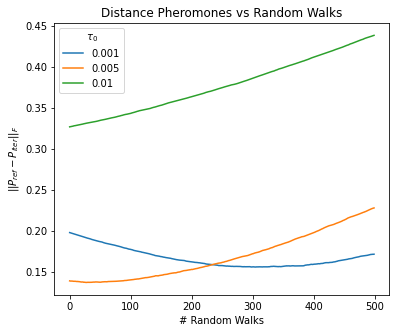

In [19]:
plot_many_distances(pheromone_distances, x_values = list(range(NUM_RW)), legend_labels = TAU_0, 
                        legend_title = r"$\tau_0$",  title = "Distance Pheromones vs Random Walks", ylabel = r"$||P_{ref} - P_{iter}||_F$")

min dist: 1130.410581258961
min dist: 1073.860488559333
min dist: 1093.546744415721


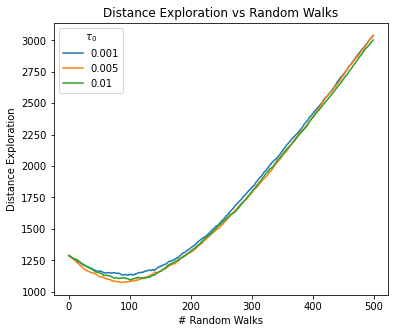

In [20]:
plot_many_distances(exploration_distances, x_values = list(range(NUM_RW)), legend_labels = TAU_0, 
                        legend_title = r"$\tau_0$",  title = "Distance Exploration vs Random Walks", ylabel = "Distance Exploration")

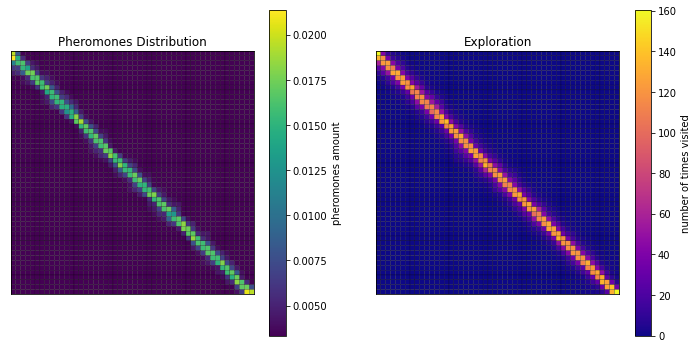

In [21]:
plot_matrixes(ref_pheromone, ref_exploration)

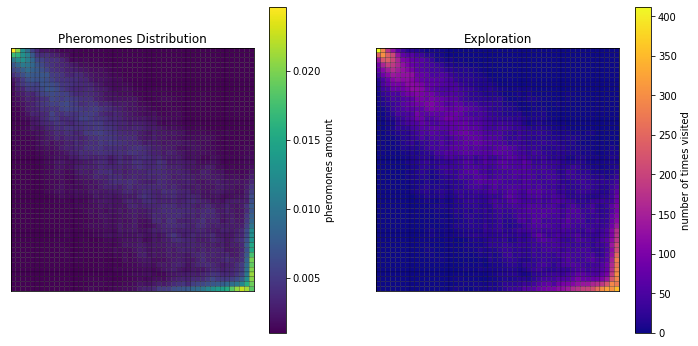

In [22]:
# tau_idx-> 0: 0.001, 1: 0.005, 2: 0.01
tau_idx = 0
iter = 350 
plot_matrixes(exp_pheromone[tau_idx,iter], exp_exploration[tau_idx,iter])

# Levy Greedy Walker -> Distribution

In [12]:
NUM_RW = 500
TAU_0 = [0.001, 0.005, 0.01]
SIZE = 50

reference_file = os.path.join(REFERENCE_DIR, f"env_{SIZE}_pheromones_avg.npy")
ref_pheromone = np.load(reference_file)

reference_file = os.path.join(REFERENCE_DIR, f"env_{SIZE}_exploration_avg.npy")
ref_exploration = np.load(reference_file)


sim_pheromone_per_tau = []
sim_exploration_per_tau = []

for tau_0_value in TAU_0:
    graph = ge.PPGraph(size=SIZE, tau_0=tau_0_value)
    walker = rw.LevyFlightGreedyWalker(graph, 
                                            q_0 = 0.8,
                                            omega = 3,
                                            advantage = 3)
    list_distance1 = []
    list_distance2 = []
    list_distance3 = []
    list_distance4 = []

    for i in range(NUM_RW):
        _ = walker.walk(1, verbose = False)
        walker.reinforce_rw()
        pheromones = walker.graph.get_pheromones_matrix()
        exploration = walker.graph.get_exploration_matrix()

        distance = get_distance(ref_pheromone, pheromones)
        list_distance1.append(distance)

        distance = get_distance(ref_pheromone, pheromones, 2)
        list_distance2.append(distance)

        distance = get_distance(ref_exploration, exploration)
        list_distance3.append(distance)

        distance = get_distance(ref_exploration, exploration, 2)
        list_distance4.append(distance)
        
    sim_pheromone_per_tau.append(list_distance1)
    sim_exploration_per_tau.append(list_distance3)

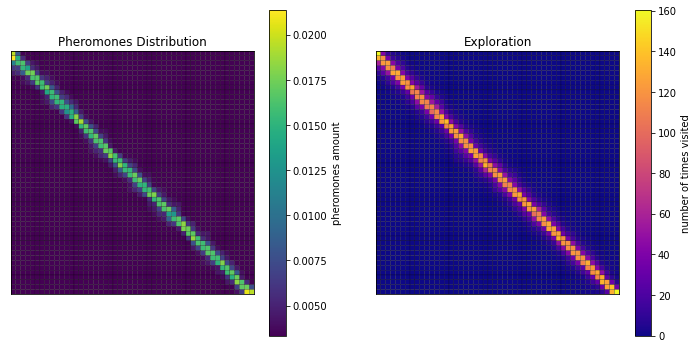

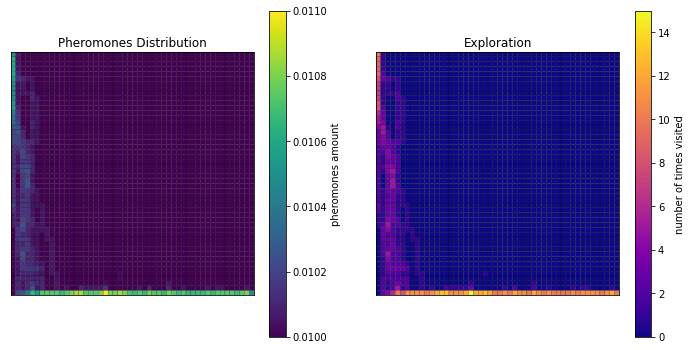

In [13]:
reference_file = os.path.join(REFERENCE_DIR, f"env_{SIZE}_pheromones_avg.npy")
ref_pheromone = np.load(reference_file)

reference_file = os.path.join(REFERENCE_DIR, f"env_{SIZE}_exploration_avg.npy")
ref_exploration = np.load(reference_file)
plot_matrixes(ref_pheromone, ref_exploration)

pheromones = walker.graph.get_pheromones_matrix()
exploration = walker.graph.get_exploration_matrix()

plot_matrixes(pheromones, exploration)

min dist: 7.429355074647445
min dist: 5.0421937266052215
min dist: 16.25636793998216


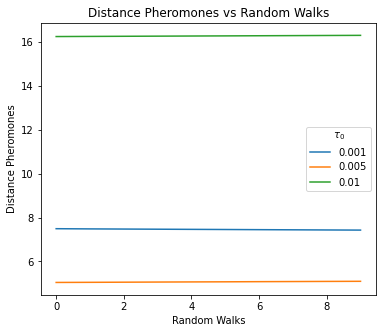

In [14]:
plot_many_distances(sim_pheromone_per_tau, x_values = list(range(NUM_RW)), legend_labels = TAU_0, 
                        legend_title = r"$\tau_0$",  title = "Distance Pheromones vs Random Walks", ylabel = "Distance Pheromones")

min dist: 19040.466666666667
min dist: 19037.866666666665
min dist: 19031.533333333333


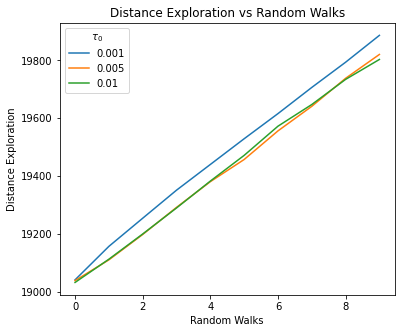

In [15]:
plot_many_distances(sim_exploration_per_tau, x_values = list(range(NUM_RW)), legend_labels = TAU_0, 
                        legend_title = r"$\tau_0$",  title = "Distance Exploration vs Random Walks", ylabel = "Distance Exploration")

# Levy Proximity Walker -> Distribution

In [24]:
NUM_RW = 600
TAU_0 = [0.001, 0.005, 0.01]
SIZE = 50

reference_file = os.path.join(REFERENCE_DIR, f"env_{SIZE}_pheromones_avg.npy")
ref_pheromone = np.load(reference_file)

reference_file = os.path.join(REFERENCE_DIR, f"env_{SIZE}_exploration_avg.npy")
ref_exploration = np.load(reference_file)


sim_pheromone_per_tau = []
sim_exploration_per_tau = []

for tau_0_value in TAU_0:
    graph = ge.PPGraph(size=SIZE, tau_0=tau_0_value)
    walker = rw.LevyFlightProximityWalker(graph, 
                                q_0 = 0.8, 
                                omega = 3,
                                proximity_mode = "proximity_2")
    list_distance1 = []
    list_distance2 = []
    list_distance3 = []
    list_distance4 = []

    for i in range(NUM_RW):
        _ = walker.walk(1, verbose = False)
        walker.reinforce_rw()
        pheromones = walker.graph.get_pheromones_matrix()
        exploration = walker.graph.get_exploration_matrix()

        distance = get_distance(ref_pheromone, pheromones)
        list_distance1.append(distance)

        distance = get_distance(ref_pheromone, pheromones, 2)
        list_distance2.append(distance)

        distance = get_distance(ref_exploration, exploration)
        list_distance3.append(distance)

        distance = get_distance(ref_exploration, exploration, 2)
        list_distance4.append(distance)
        
    sim_pheromone_per_tau.append(list_distance1)
    sim_exploration_per_tau.append(list_distance3)

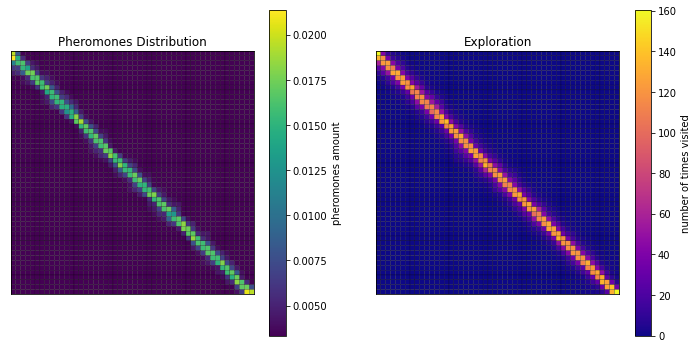

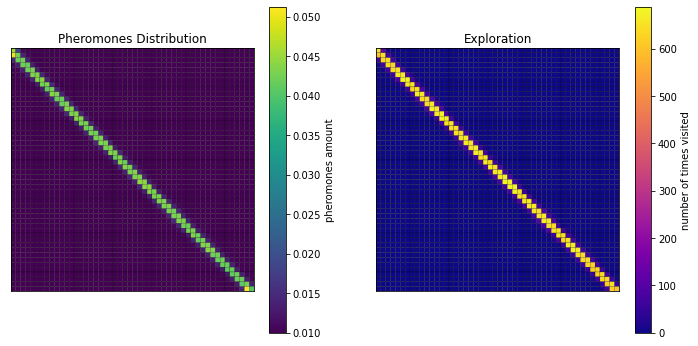

In [25]:
reference_file = os.path.join(REFERENCE_DIR, f"env_{SIZE}_pheromones_avg.npy")
ref_pheromone = np.load(reference_file)

reference_file = os.path.join(REFERENCE_DIR, f"env_{SIZE}_exploration_avg.npy")
ref_exploration = np.load(reference_file)
plot_matrixes(ref_pheromone, ref_exploration)

pheromones = walker.graph.get_pheromones_matrix()
exploration = walker.graph.get_exploration_matrix()

plot_matrixes(pheromones, exploration)

min dist: 5.892253877626903
min dist: 3.9841014131646
min dist: 15.807322267488802


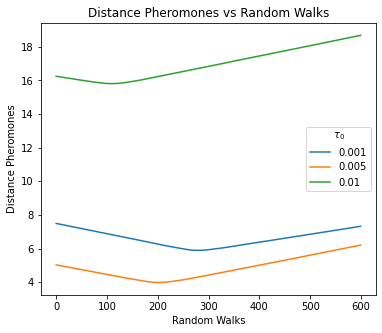

In [26]:
plot_many_distances(sim_pheromone_per_tau, x_values = list(range(NUM_RW)), legend_labels = TAU_0, 
                        legend_title = r"$\tau_0$",  title = "Distance Pheromones vs Random Walks", ylabel = "Distance Pheromones")

min dist: 6294.8
min dist: 6466.333333333334
min dist: 6253.266666666667


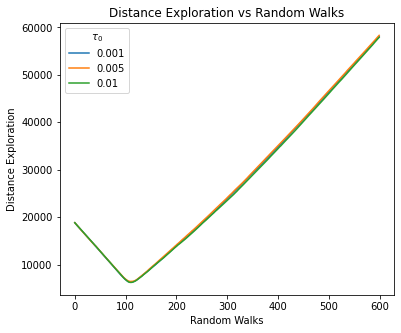

In [27]:
plot_many_distances(sim_exploration_per_tau, x_values = list(range(NUM_RW)), legend_labels = TAU_0, 
                        legend_title = r"$\tau_0$",  title = "Distance Exploration vs Random Walks", ylabel = "Distance Exploration")